<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/020_SINDy_Proj_Twenty_PlasmaPhysics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref: https://arxiv.org/pdf/2004.10389.pdf

In [ ]:
!pip install pysindy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 1.8 MB/s eta 0:00:00


In [ ]:
# utils
import os, sys
import warnings
import numpy as np
from scipy.integrate.odepack import ODEintWarning
# google
from google.colab import drive
#sindy
import pysindy as ps
# vis
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

<ipython-input-6-86be0f49d369>:5: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


In [ ]:
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

In [ ]:
drive.mount('/content/drive') # mount google drive

Mounted at /content/drive


In [ ]:
working_dir = '/content/drive/MyDrive/DataSets/PySINDy_Data'
os.listdir(working_dir)

['kuramoto_sivishinky.mat',
 'cavityPOD.mat',
 'PODcoefficients_run1.mat',
 'cavityGalerkin.mat',
 'optimizer_summary.jpg',
 'kdv.mat',
 'burgers.mat',
 'plasmaphysics_example_singularValues.txt',
 'plasmaphysics_example_trajectories.txt',
 'burgers_highres2.mat',
 'PODcoefficients.mat',
 'burgers_highres1.mat',
 'vonKarman_pod',
 'auto']

In [ ]:
os.chdir(working_dir)
assert os.getcwd() == working_dir

In [ ]:
def pareto_curve(
    optimizer,
    feature_library,
    differentiation_method,
    feature_names,
    discrete_time,
    thresholds,
    x_fit,
    x_test,
    t_fit,
    t_test,
    energies):
    """
    Function which sweeps out a Pareto Curve in (r, lambda)

    Parameters
    ----------

    optimizer : optimizer object, optional
        Optimization method used to fit the SINDy model. This must be a class
        extending :class:`pysindy.optimizers.BaseOptimizer`.
        The default is :class:`STLSQ`.

    feature_library : feature library object, optional
        Feature library object used to specify candidate right-hand side features.
        This must be a class extending
        :class:`pysindy.feature_library.base.BaseFeatureLibrary`.
        The default option is :class:`PolynomialLibrary`.

    differentiation_method : differentiation object, optional
        Method for differentiating the data. This must be an object that
        extends :class:`pysindy.differentiation_methods.BaseDifferentiation`.
        Default is centered difference.

    feature_names : list of string, length n_input_features, optional

    discrete_time : boolean, optional (default False)
        If True, dynamical system is treated as a map. Rather than predicting
        derivatives, the right hand side functions step the system forward by
        one time step. If False, dynamical system is assumed to be a flow
        (right hand side functions predict continuous time derivatives).

    thresholds: array of floats
        The list of thresholds to change the number of terms available to the
        SINDy model, generating a Pareto curve.

    x_fit: array-like or list of array-like, shape
        (n_samples, n_input_features)
        Training data.

    x_test: array-like or list of array-like, shape
        (n_samples, n_input_features)
        Testing data.

    t_fit: array of floats
        Time slices corresponding to the training data.

    t_test: array of floats
        Time slices corresponding to the testing data.

    energies: array of floats
        Singular values of the data
    """
    model_scores = []
    non_zeros_coeffs = []
    x_err = []
    xdot_err = []
    integrator_keywords = {}
    integrator_keywords['rtol'] = 1e-20
    integrator_keywords['h0'] = 1e-5

    # loop over the threshold values of interest
    for j in range(len(thresholds)):
        optimizer.threshold = thresholds[j]
        model = ps.SINDy(
            optimizer=optimizer,
            feature_library=feature_library,
            differentiation_method=differentiation_method(drop_endpoints=True),
            feature_names=feature_names,
            discrete_time=discrete_time,
        )

        # compute predicted X and Xdot
        model.fit(x_fit, t=t_fit, quiet=True)
        x_init = x_test[0, :]
        x_sim = model.simulate(
            x_init,
            t_test,
            integrator="odeint",
            integrator_kws=integrator_keywords,
        )
        xdot_test = model.differentiate(x_test, t=t_test)[1:-2]
        xdot_sim = model.predict(x_test)[1:-2]

        # compute normalized Frobenius error of X and Xdot on the "testing" data
        x_err.append(np.sqrt(np.mean(np.mean((x_test - x_sim) ** 2, axis=0) * energies**2) / np.mean(np.mean(x_test ** 2, axis=0) * energies**2)))
        xdot_err.append(np.sqrt(np.mean(np.mean((xdot_test - xdot_sim) ** 2, axis=0) * energies**2) / np.mean(np.mean(xdot_test ** 2, axis=0) * energies**2)))
        num_coeff = len(np.ravel(model.coefficients()))
        num_nonzero_coeff = np.count_nonzero(model.coefficients())
        non_zeros_coeffs.append(num_nonzero_coeff / num_coeff * 100)
        model_scores.append(min((1 - min(model.score(x_test, t=t_test), 1)) * 100, 100))
    # save the errors and other metrics of model performance to file
    errs = np.zeros((len(model_scores), 5))
    errs[:, 0] = non_zeros_coeffs
    errs[:, 1] = thresholds
    errs[:, 2] = model_scores
    errs[:, 3] = x_err
    errs[:, 4] = xdot_err
    return errs

In [ ]:
cmap = plt.get_cmap("Set1")
def plot_trajectories(x, x_train, x_sim, n_modes=None):
    """
    Compare x (the true data), x_train (predictions on the training data),
    and x_sim (predictions on the test data).
    """
    if n_modes is None:
        n_modes = x_sim.shape[1]
    n_rows = (n_modes + 1) // 2
    kws = dict(alpha=0.7)
    fig, axs = plt.subplots(n_rows, 2, figsize=(12, 2 * (n_rows + 1)), sharex=True)
    for i, ax in zip(range(n_modes), axs.flatten()):
        ax.plot(t, x[:, i], color="Gray", label="True", **kws)
        ax.plot(t_train, x_train[:, i], color=cmap(1),
                label="Predicted (train)", **kws)
        ax.plot(t_test, x_sim[:, i], color=cmap(0),
                label="Predicted (test)", **kws)
    for ax in axs.flatten():
        ax.grid(True)
        ax.set(xticklabels=[], yticklabels=[])
    fig.tight_layout()

In [ ]:
def plot_coefficients(coefficients, input_features=None,
                      feature_names=None, ax=None, **heatmap_kws):
    """Plot learned coefficient matrix in human-readable way."""
    if input_features is None:
        input_features = [f"$\dot x_{k}$" for k in range(coefficients.shape[0])]
    else:
        input_features = [f"$\dot {fi}$" for fi in input_features]

    if feature_names is None:
        feature_names = [f"f{k}" for k in range(coefficients.shape[1])]
    max_ind = len(feature_names)
    with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
        if ax is None:
            fig, ax = plt.subplots(1, 1)
        max_mag = np.max(np.abs(coefficients))
        heatmap_args = {
            "xticklabels": input_features,
            "yticklabels": feature_names,
            "center": 0.0,
            "cmap": sns.color_palette("vlag", n_colors=20),
            "ax": ax,
            "linewidths": 0.1,
            "linecolor": "whitesmoke"}
        heatmap_args.update(**heatmap_kws)
        sns.heatmap(coefficients[:, :max_ind].T, **heatmap_args)
        ax.tick_params(axis="y", rotation=0)
    return ax

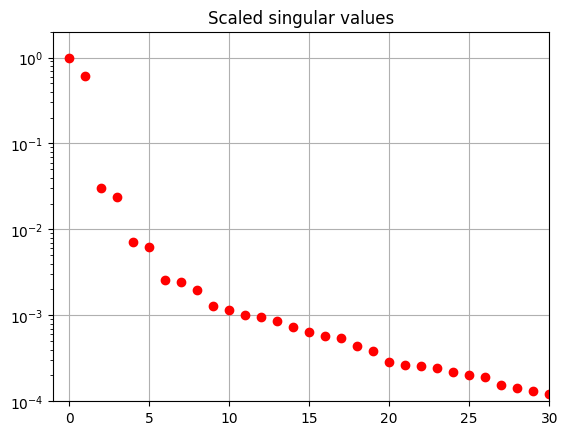

In [ ]:
A = np.loadtxt("./plasmaphysics_example_trajectories.txt") # load in temporal POD modes of a plasma simulation (trajectories in time)
t = A[:, 0]
A = A[:,1:]
S = np.loadtxt("./plasmaphysics_example_singularValues.txt") # load in the corresponding SVD data and plot it
fig, ax = plt.subplots(1, 1)
ax.semilogy(S / S[0], "ro")
ax.set(title="Scaled singular values", xlim=[-1, 30], ylim=[1e-4, 2])
ax.grid()

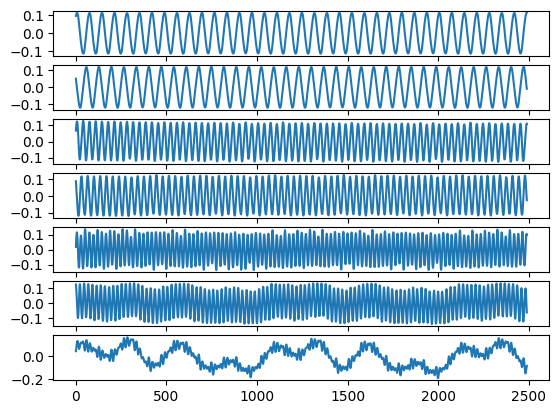

In [ ]:
r = 7
poly_order = 2
threshold = 0.05
tfrac = 0.8  # proportion of the data to train on
M = len(t)
M_train = int(len(t) * tfrac)
t_train = t[:M_train]
t_test = t[M_train:]
pod_names = ["a{}".format(i) for i in range(1, r + 1)]
normalization = sum(np.amax(abs(A), axis=0)[1:r + 1]) # normalize the trajectories to the unit ball for simplicity
x = np.zeros((A.shape[0], r))
plt.figure()
for i in range(r):
    x[:, i] = A[:, i] / normalization
    plt.subplot(r, 1, i + 1)
    plt.plot(x[:, i])
# build an initial guess
initial_guess = np.zeros((r,r + int(r * (r + 1) / 2)))
initial_guess[0, 1] = 0.091
initial_guess[1, 0] = -0.091
initial_guess[2, 3] = 0.182
initial_guess[3, 2] = -0.182
initial_guess[5, 4] = -3 * 0.091
initial_guess[4, 5] = 3 * 0.091
x_train = x[:M_train, :]
x_init_train = x[0, :]
x_test = x[M_train:, :]
x_init_test = x[M_train, :]

In [ ]:
# we need a quadratic library with particular ordering for the model constraints that we use later
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)
sindy_opt = ps.SR3(
    threshold=threshold, nu=1,
    initial_guess=initial_guess, max_iter=1000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names)
model.fit(x_train, t=t_train)
model.print()

(a1)' = 0.090 a2
(a2)' = -0.091 a1
(a3)' = 0.179 a4
(a4)' = -0.179 a3
(a5)' = 0.263 a6
(a6)' = -0.263 a5
(a7)' = 0.000


<Axes: >

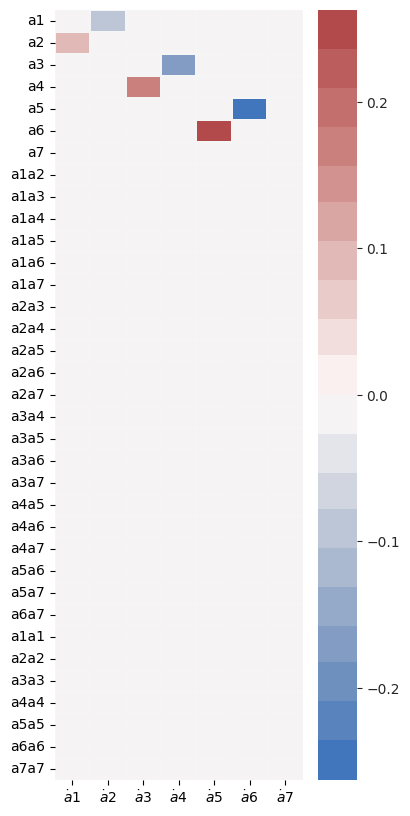

In [ ]:
feature_names = model.get_feature_names()
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(),
                  input_features=pod_names,
                  feature_names=feature_names,
                  ax=ax)

In [ ]:
x_dot = model.differentiate(x, t=t)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)
print("Model score:", model.score(x, t=t))

Model score: 0.8315081674949204


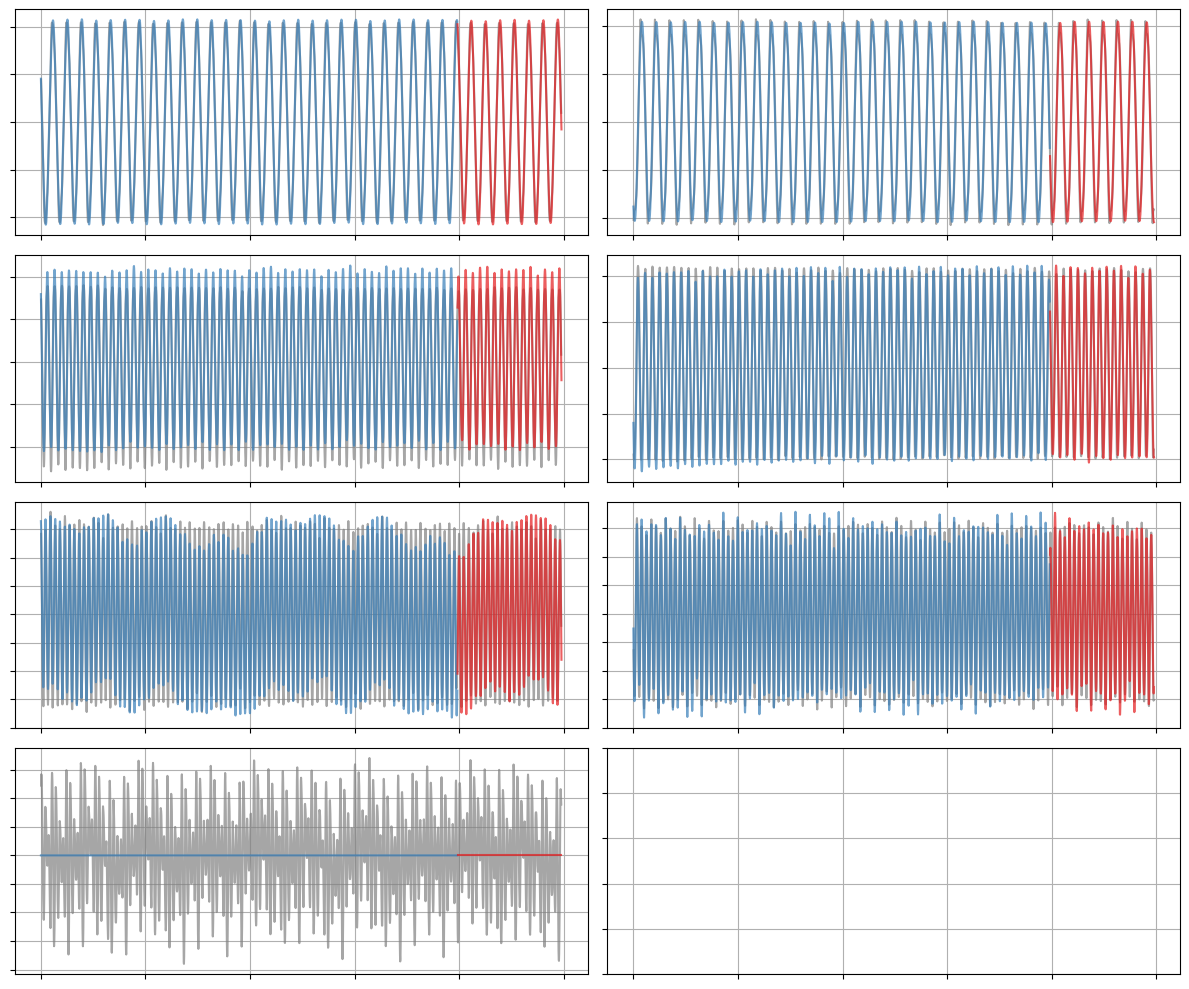

In [ ]:
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

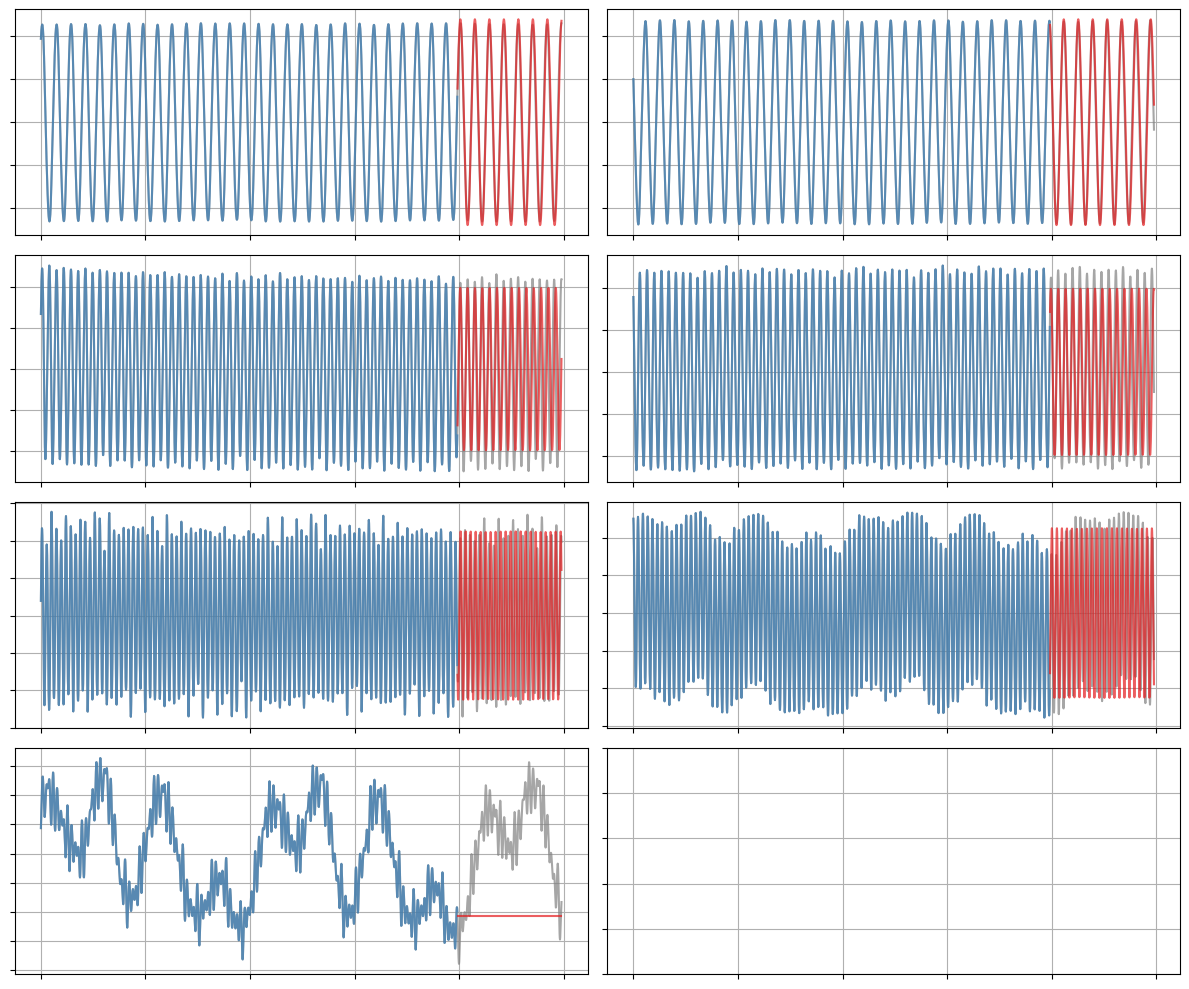

In [ ]:
x_simul = model.simulate(x_init_test, t_test)
plot_trajectories(x, x_train, x_simul, n_modes=r)

In [ ]:
threshold = 0.05
constraint_zeros = np.zeros(int(r * (r + 1) / 2))
constraint_matrix = np.zeros((int(r * (r + 1) / 2),
                              int(r * (r ** 2 + 3 * r) / 2)))
q = r
for i in range(r):
    constraint_matrix[i, i * (r + 1)] = 1.0
    counter = 1
    for j in range(i + 1, r):
        constraint_matrix[q, i * r + j] = 1.0
        constraint_matrix[q, i * r + j + counter * (r - 1)] = 1.0
        counter += 1
        q += 1
sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    nu=1,
    max_iter=10000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    tol=1e-6,
    initial_guess=initial_guess)

In [ ]:
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names)
model.fit(x_train, t=t_train)
model.print()

(a1)' = 0.091 a2
(a2)' = -0.091 a1
(a3)' = 0.179 a4
(a4)' = -0.179 a3
(a5)' = 0.263 a6
(a6)' = -0.263 a5
(a7)' = 0.000


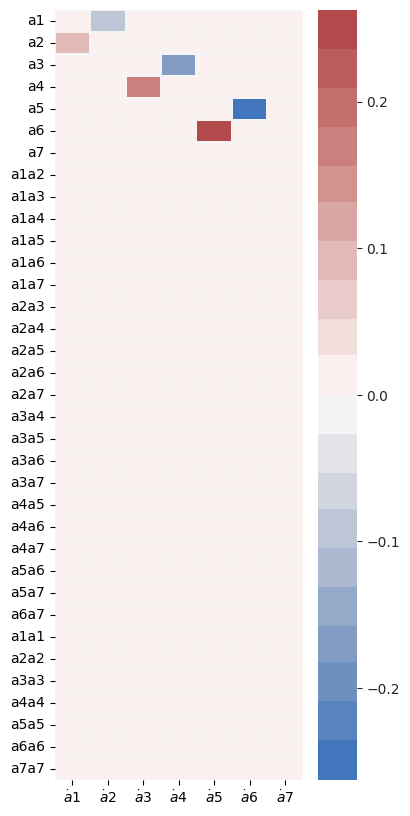

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(),
                  input_features=pod_names,
                  feature_names=feature_names,
                  ax=ax);

In [ ]:
print("Model score:", model.score(x, t=t))

Model score: 0.8315075123206278


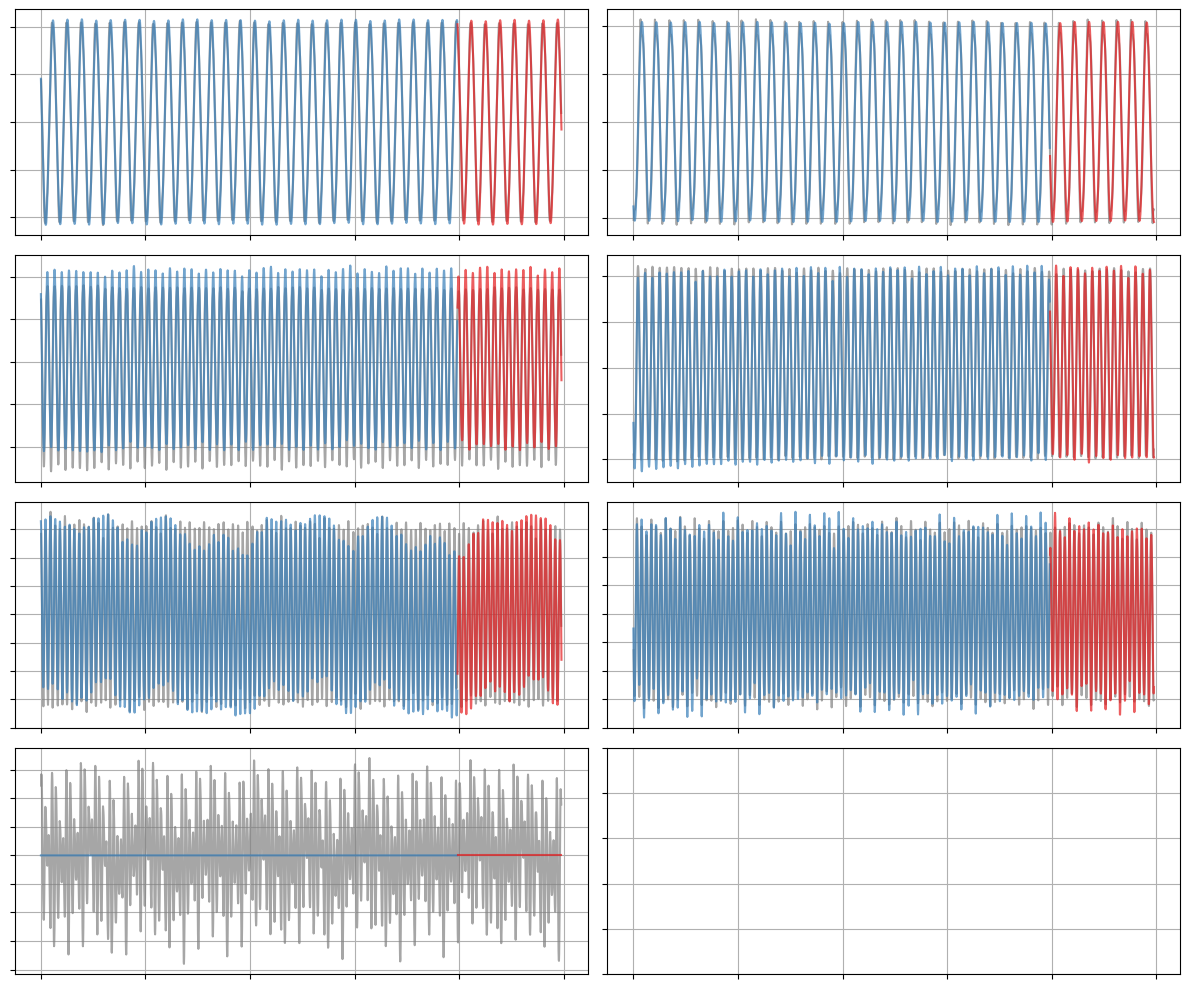

In [ ]:
x_dot = model.differentiate(x, t=t)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

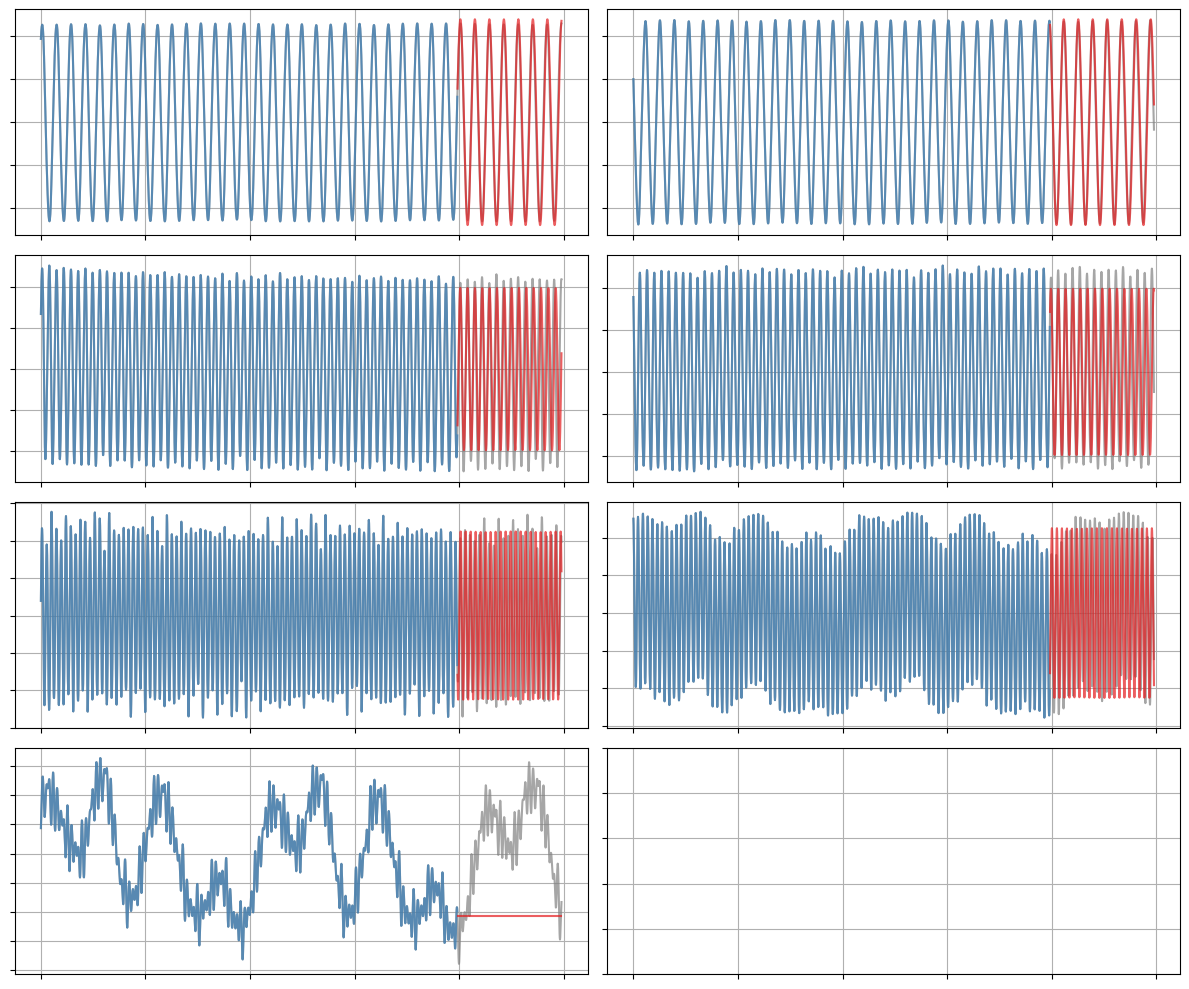

In [ ]:
x_sim = model.simulate(x_init_test, t_test)
plot_trajectories(x, x_train, x_sim, r)

(a1)' = 0.091 a2
(a2)' = -0.091 a1
(a3)' = 0.179 a4
(a4)' = -0.179 a3
(a5)' = 0.262 a6 + -0.052 a7
(a6)' = -0.262 a5
(a7)' = 0.052 a5
Model score: 0.8754167424876458


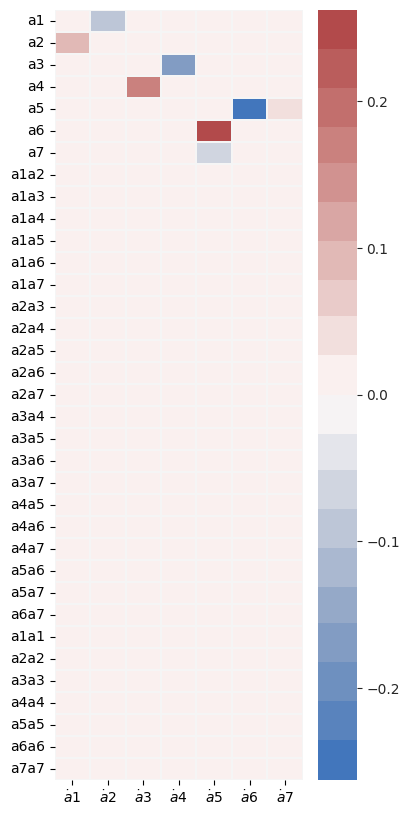

In [ ]:
threshold = 0.05
thresholder = "weighted_l0"
thresholds = threshold * np.ones((r + int(r * (r + 1) / 2), r))
thresholds[r:, :] = 30 * threshold
sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    nu=10,
    max_iter=50000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    tol=1e-5,
    thresholder=thresholder,
    initial_guess=initial_guess,
    thresholds=thresholds)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names)
model.fit(x_train, t=t_train)
model.print()
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(),
                  input_features=pod_names,
                  feature_names=feature_names,
                  ax=ax)
x_dot = model.differentiate(x, t=t)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)
print("Model score:", model.score(x, t=t))

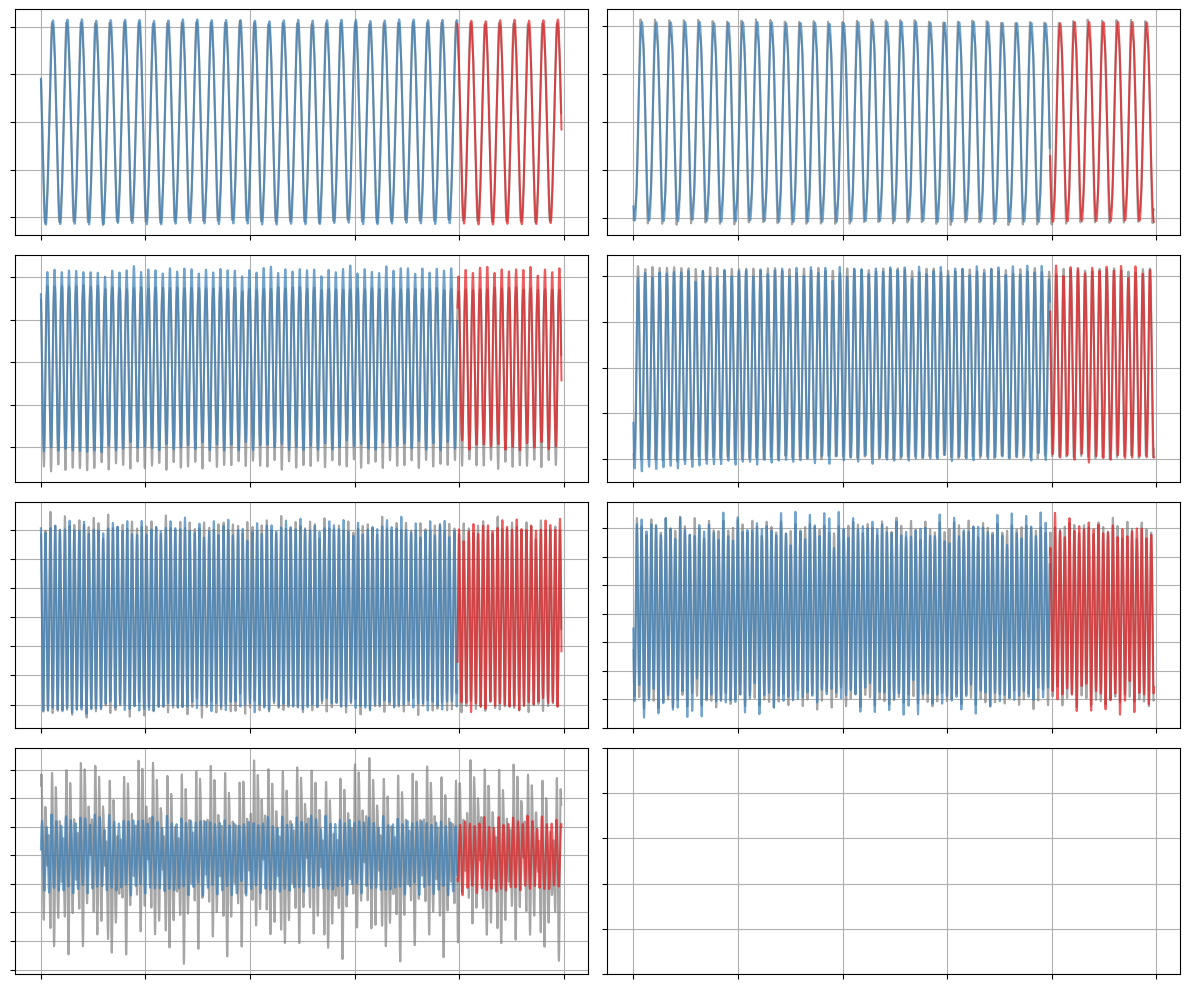

In [ ]:
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

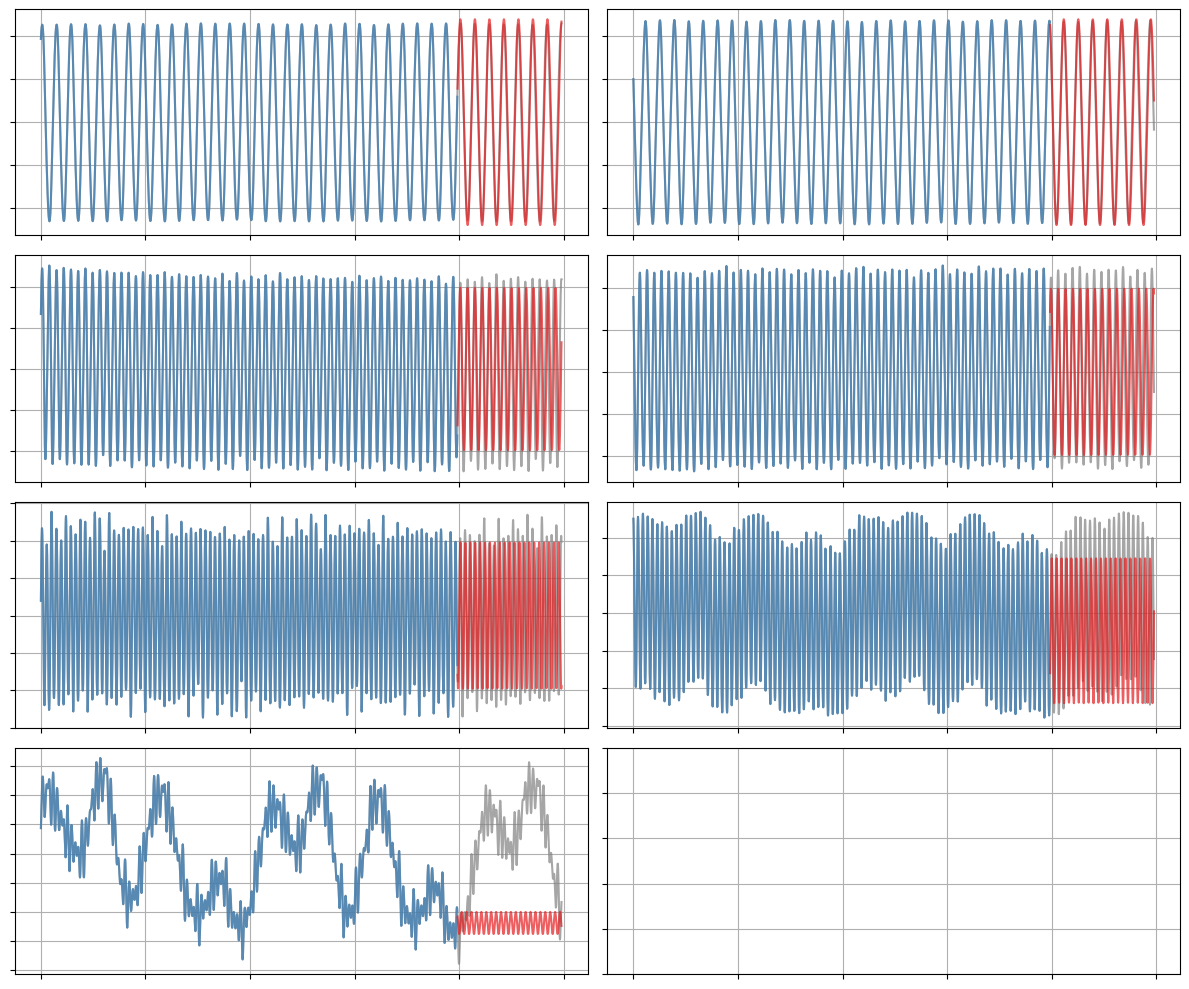

In [ ]:
x_simul = model.simulate(x_init_test, t_test)
plot_trajectories(x, x_train, x_simul, n_modes=r)

(a1)' = 0.091 a2
(a2)' = -0.091 a1
(a3)' = 0.179 a4
(a4)' = -0.179 a3 + -0.093 a1a6 + -0.090 a2a5 + -0.090 a3a4
(a5)' = 0.262 a6 + -0.052 a7 + -0.030 a2a5 + 0.049 a3a5 + 0.077 a3a7 + -0.041 a4a6
(a6)' = -0.262 a5 + -0.034 a4a6 + -0.113 a4a7
(a7)' = 0.052 a5 + 0.161 a1a5 + 0.193 a1a6 + 0.165 a2a5 + -0.150 a2a6 + 0.173 a3a4 + 0.051 a4a6 + 0.157 a3a3 + -0.165 a4a4


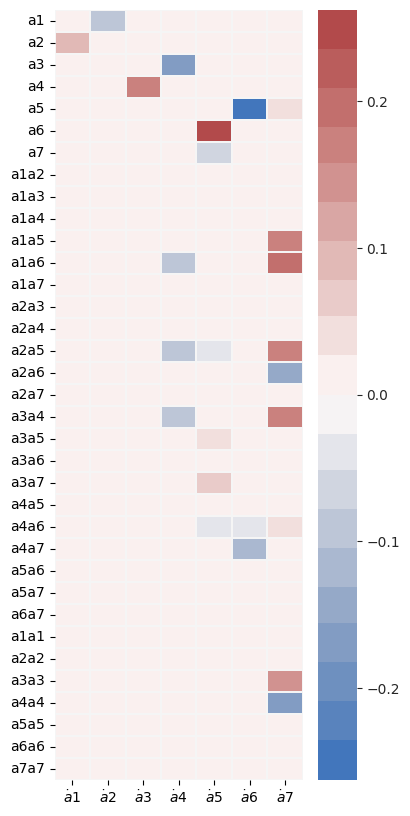

In [ ]:
threshold = 0.05
thresholder = "weighted_l0"
thresholds = threshold * np.ones((r, r + int(r * (r + 1) / 2)))
thresholds[0:2, r:] = 30 * threshold
thresholds[2, r:] = 0.2
thresholds[3, r:] = 0.05
thresholds[4:6, r:] = 0.03
thresholds = thresholds.T
sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    nu=10,
    max_iter=50000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    tol=1e-5,
    thresholder=thresholder,
    initial_guess=initial_guess,
    thresholds=thresholds,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)
model.fit(x_train, t=t_train)
model.print()
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(),
                  input_features=pod_names,
                  feature_names=feature_names,
                  ax=ax);

In [ ]:
print("Model score:", model.score(x, t=t))

Model score: 0.9579570427080192


In [ ]:
x_dot = model.differentiate(x, t=t)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)

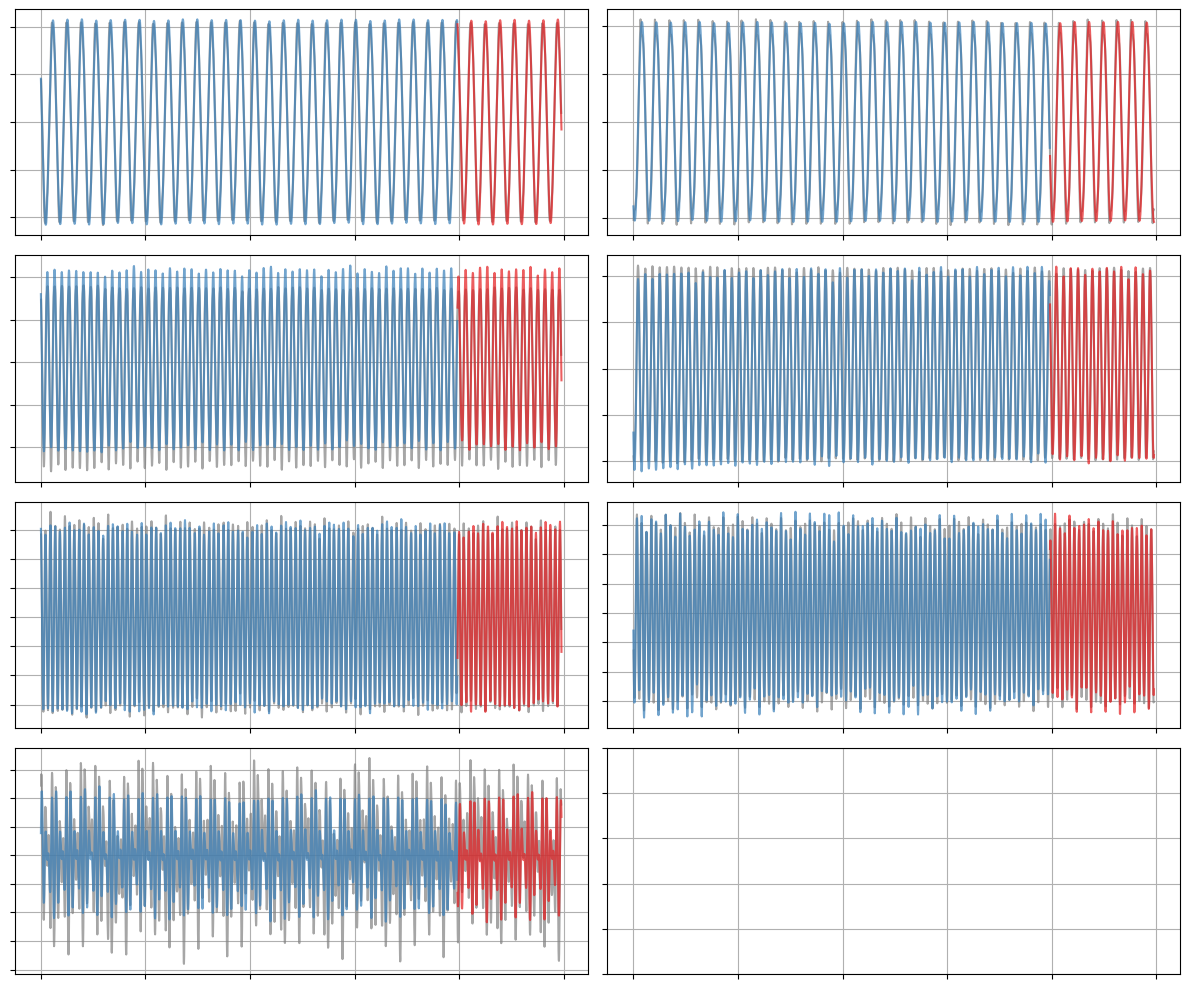

In [ ]:
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

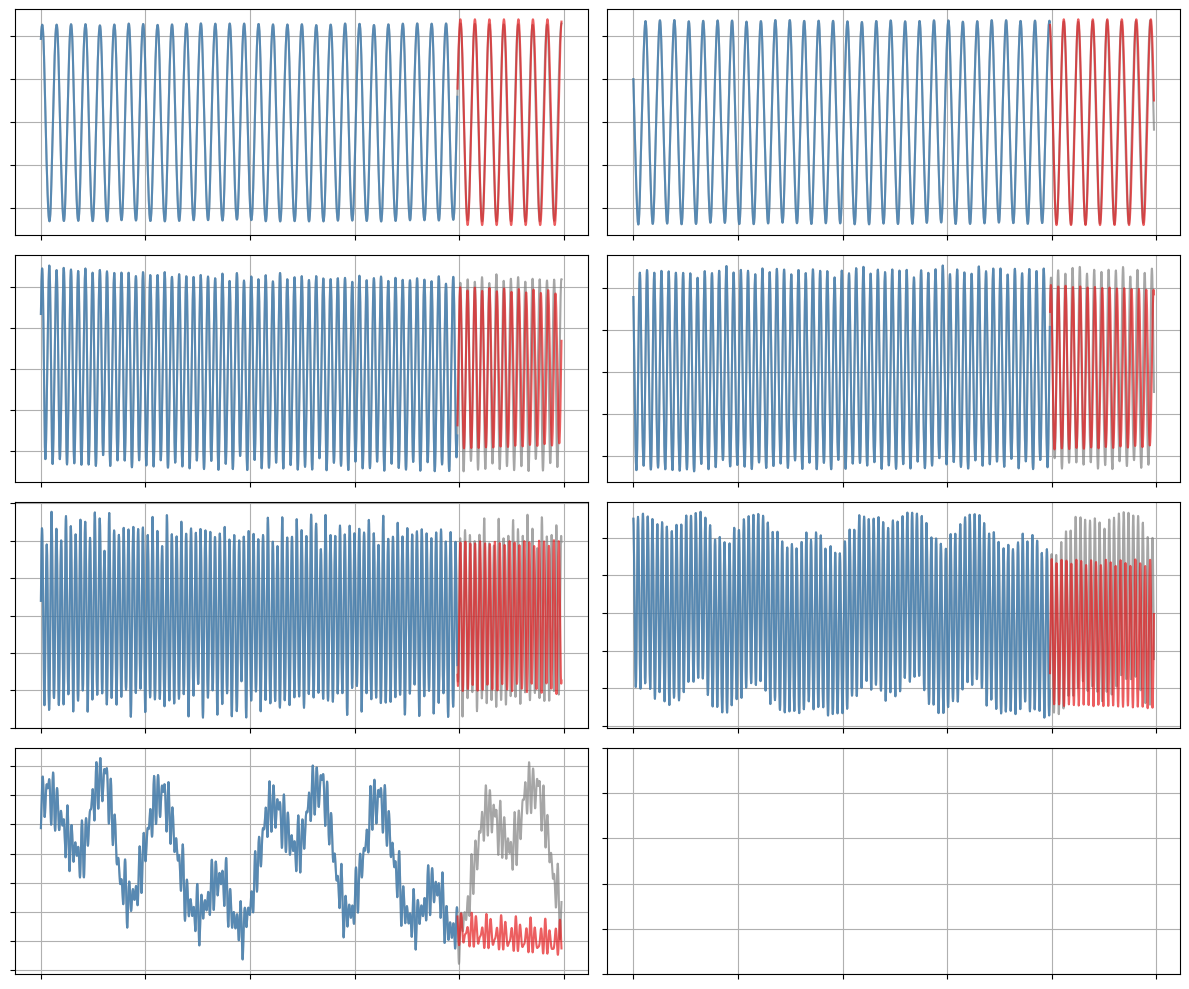

In [ ]:
x_simul = model.simulate(x_init_test, t_test)
plot_trajectories(x, x_train, x_simul, n_modes=r)

(a1)' = 0.091 a2 + 0.009 a5
(a2)' = -0.091 a1 + 0.008 a5 + -0.011 a6
(a3)' = 0.179 a4 + 0.007 a7 + -0.024 a8 + 0.026 a9
(a4)' = -0.179 a3 + 0.009 a7 + -0.027 a8 + -0.014 a9
(a5)' = -0.009 a1 + -0.008 a2 + 0.263 a6 + -0.051 a7 + -0.012 a8 + 0.007 a12 + 0.008 a14 + 0.014 a16
(a6)' = 0.011 a2 + -0.263 a5 + 0.008 a12 + 0.011 a15 + -0.016 a16
(a7)' = -0.007 a3 + -0.009 a4 + 0.051 a5 + -0.009 a8 + 0.077 a9 + 0.010 a10 + -0.008 a11 + -0.009 a12 + 0.013 a15 + 0.006 a16
(a8)' = 0.024 a3 + 0.027 a4 + 0.012 a5 + 0.009 a7 + -0.332 a9 + -0.042 a10 + 0.029 a11 + 0.021 a13 + -0.030 a1a14 + 0.053 a2a12
(a9)' = -0.026 a3 + 0.014 a4 + -0.077 a7 + 0.332 a8 + 0.031 a10 + 0.011 a11 + -0.032 a13 + 0.007 a16 + -0.134 a2a14
(a10)' = -0.010 a7 + 0.042 a8 + -0.031 a9 + 0.083 a11 + -0.031 a13 + -0.014 a14 + -0.007 a16
(a11)' = 0.008 a7 + -0.029 a8 + -0.011 a9 + -0.083 a10 + 0.010 a13 + -0.021 a14
(a12)' = -0.007 a5 + -0.008 a6 + 0.009 a7 + 0.415 a14 + 0.020 a15 + -0.020 a16 + -0.053 a2a8
(a13)' = -0.021 a8 + 0.0

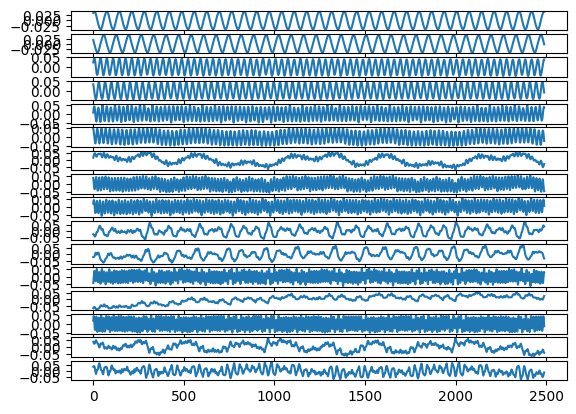

In [ ]:
r = 16
N_constraints = int(r * (r + 1) / 2) + r + r * (r - 1) + int(
    r * (r - 1) * (r - 2) / 6.0)

if poly_order == 2:
    constraint_zeros = np.zeros(N_constraints)
    constraint_matrix = np.zeros((N_constraints,
                                  int(r * (r ** 2 + 3 * r) / 2)))
    # set the diagonal part of the linear coefficient matrix to be zero
    for i in range(r):
        constraint_matrix[i, i * (r + 1)] = 1.0
    q = r
    # enforce anti-symmetry in the linear coefficient matrix
    for i in range(r):
        counter = 1
        for j in range(i + 1, r):
            constraint_matrix[q, i * r + j] = 1.0
            constraint_matrix[q, i * r + j + counter * (r - 1)] = 1.0
            counter = counter + 1
            q = q + 1
    # set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (int((r ** 2 + 3 * r) / 2.0) - r) + i * (r + 1)] = 1.0
        q = q + 1
    # set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (int((r ** 2 + 3 * r) / 2.0) - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
        for j in range(i):
            constraint_matrix[q, r * (int((r **2 + 3 * r) / 2.0) - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1
    # set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
# normalize the trajectories to the unit ball for simplicity
normalization = sum(np.amax(abs(A), axis=0)[1:r + 1])
pod_names = ["a{}".format(i) for i in range(1, r + 1)]
x = np.zeros((A.shape[0], r))
plt.figure()
for i in range(r):
    x[:, i] = A[:, i] / normalization
    plt.subplot(r, 1, i+1)
    plt.plot(x[:, i])
# build an initial guess
initial_guess = np.zeros((r, r + int(r * (r + 1) / 2)))
initial_guess[0, 1] = 0.091
initial_guess[1, 0] = -0.091
initial_guess[2, 3] = 0.182
initial_guess[3, 2] = -0.182
initial_guess[5, 4] = -3 * 0.091
initial_guess[4, 5] = 3 * 0.091
x_train = x[:M_train, :]
x_init_train = x[0, :]
x_test = x[M_train:, :]
x_init_test = x[M_train, :]
sindy_opt = ps.ConstrainedSR3(
    threshold=0.004,
    nu=1,
    max_iter=600,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    tol=1e-5,
    thresholder='l0',
    initial_guess=initial_guess)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names)
model.fit(x_train, t=t_train, quiet=True)
model.print()

<Axes: >

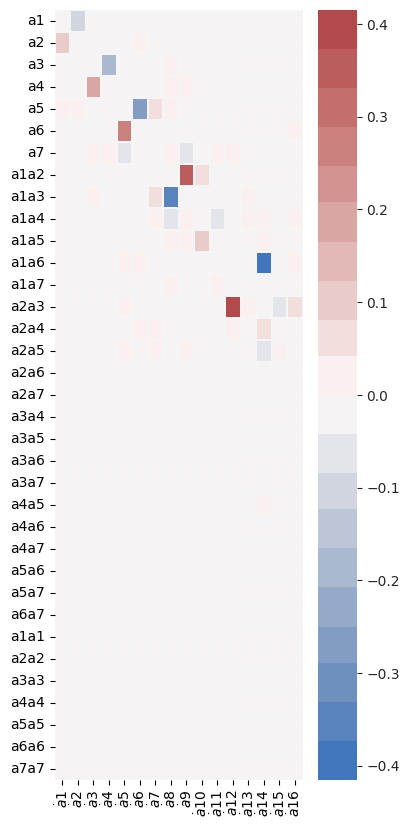

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(),
                  input_features=pod_names,
                  feature_names=feature_names,
                  ax=ax)

In [ ]:
print("Model score:", model.score(x, t=t))

Model score: 0.8738485575128806


In [ ]:
x_dot = model.differentiate(x, t=t)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)

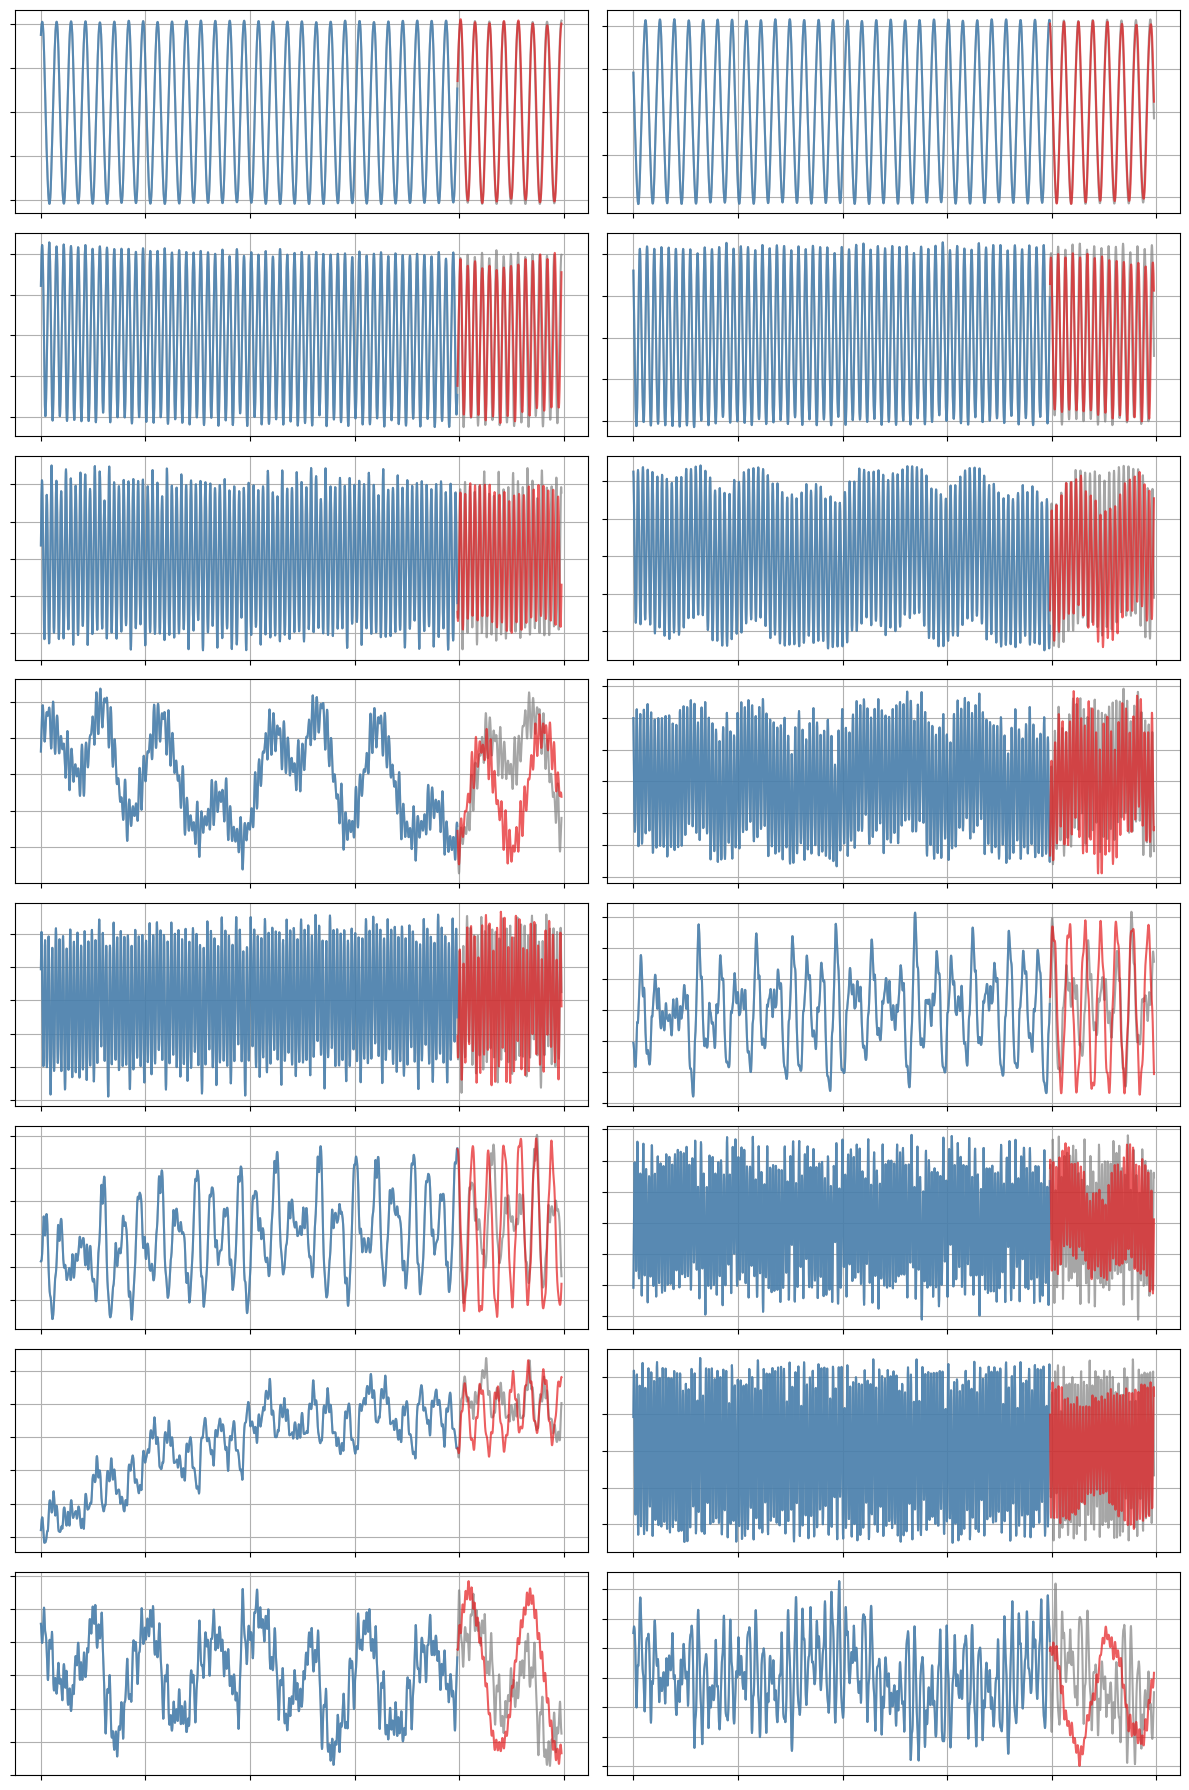

In [ ]:
x_simul = model.simulate(x_init_test, t_test)
plot_trajectories(x, x_train, x_simul, n_modes=r)

In [ ]:
lambda_length = 50
threshold = 0.005
# threshold values to map out
pareto_thresholds = np.linspace(0.0, 30.0 * threshold, lambda_length)
poly_order = 2
tfrac = 0.8
rmax = 13
M = len(t)
M_train = int(len(t) * tfrac)
t_train = t[:M_train]
t_test = t[M_train:]
# scanning models (coupled, quadratically nonlinear ODEs) with 3-14 modes
r_scan = range(3, rmax)
r_length = len(r_scan)
rl_errs = np.zeros((r_length, lambda_length, 5))
for r_current in r_scan:
    print("r = ", r_current)
    energies = S[:r_current]
    pod_names = ["a{}".format(i) for i in range(1, r_current + 1)]
    # normalize the trajectories to the unit ball for simplicity
    normalization = sum(np.amax(abs(A), axis=0)[1:r_current + 1])
    x = A[:, :r_current] / normalization
    # build an initial guess
    initial_guess = np.zeros((r_current, r_current + int(r_current * (r_current + 1) / 2)))
    initial_guess[0, 1] = 0.091
    initial_guess[1, 0] = -0.091
    # split data into training and testing
    x_train = x[:M_train, :]
    x_init_train = x[0, :]
    x_test = x[M_train:, :]
    x_init_test = x[M_train, :]
    # special library ordering needed again if constraints are used
    library_functions = [lambda x: x, lambda x, y: x * y, lambda x: x ** 2]
    library_function_names = [lambda x: x, lambda x, y: x + y, lambda x: x + x]
    sindy_library = ps.CustomLibrary(
        library_functions=library_functions,
        function_names=library_function_names)
    sindy_opt = ps.ConstrainedSR3(
        threshold=threshold, nu=1,
        initial_guess=initial_guess,
        max_iter=1000)
    rl_errs[r_current - r_scan[0], :, :] = pareto_curve(
        sindy_opt,
        sindy_library,
        ps.FiniteDifference,
        feature_names,
        discrete_time=False,
        thresholds=pareto_thresholds,
        x_fit=x_train,
        x_test=x_test,
        t_fit=t_train,
        t_test=t_test,
        energies=energies)

r =  3
r =  4
r =  5
r =  6
r =  7
r =  8
r =  9
r =  10
r =  11
r =  12


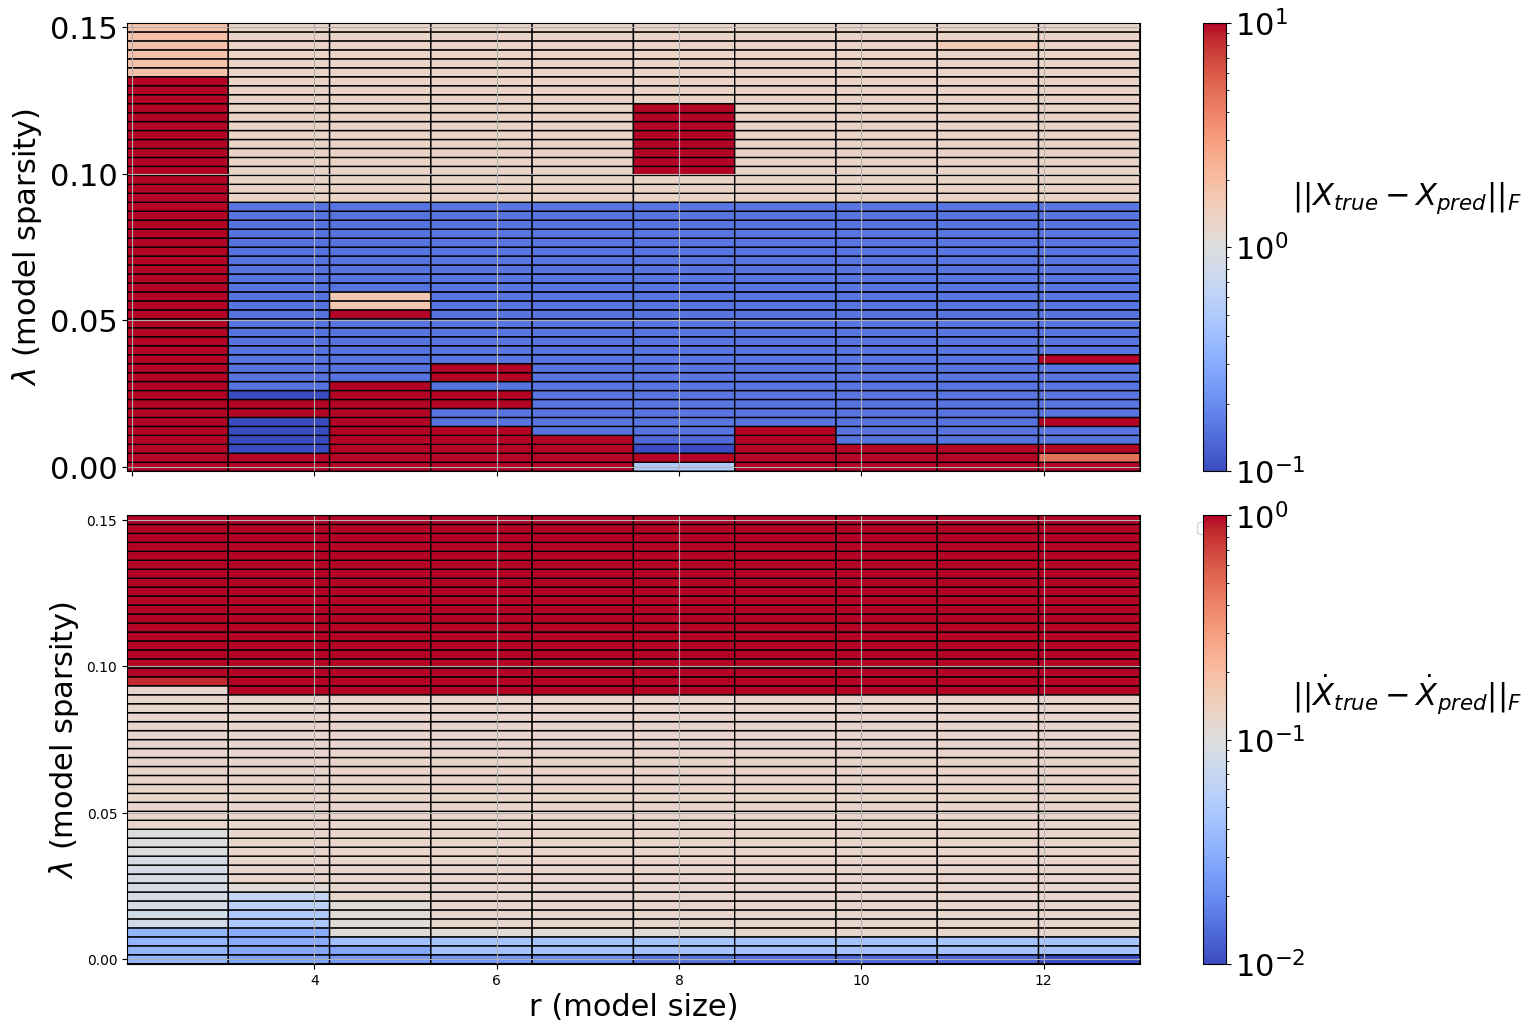

In [ ]:
nonzeros = np.zeros((r_length, lambda_length))
scores = np.zeros((r_length, lambda_length))
xerr = np.zeros((r_length, lambda_length))
xdoterr = np.zeros((r_length, lambda_length))
alpha = 0.7
for i in r_scan:
    nonzero_coeffs = rl_errs[i - r_scan[0], :, 0]
    thresholds = rl_errs[i - r_scan[0], :, 1]
    model_scores = rl_errs[i - r_scan[0], :, 2]
    x_err = rl_errs[i - r_scan[0], :, 3]
    xdot_err = rl_errs[i - r_scan[0], :, 4]
    nonzeros[i - r_scan[0], :] = nonzero_coeffs
    scores[i - r_scan[0], :] = model_scores
    xerr[i - r_scan[0], :] = x_err
    xdoterr[i - r_scan[0], :] = xdot_err
fig, axs = plt.subplots(2, 1, figsize=(14, 10))
for ax in axs:
    ax.grid(True)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
fig.tight_layout()
fig.show()
X, Y = np.meshgrid(
    np.linspace(r_scan[0], r_scan[-1] + 1, r_length) - 0.5,
    thresholds,
    indexing="ij")
# truncate exploding errors at 1e2 for visualization's sake
xerr[np.isnan(xerr)] = 1e1
xerr[xerr > 1e1] = 1e1
xdoterr[np.isnan(xdoterr)] = 1e1
xdoterr[xdoterr > 1e1] = 1e1
c0 = axs[0].pcolor(
    X,
    Y,
    xerr,
    norm=LogNorm(vmin=1e-1, vmax=1e1),
    cmap="coolwarm",
    edgecolors="k",
    linewidths=1)
fs = 22
axs[0].set_xticklabels([])
axs[0].set_yticks([0, 0.05, 0.1, 0.15])
axs[0].set_yticklabels(['0.00', '0.05', '0.10', '0.15'], fontsize=fs)
axs[0].set_ylabel(r"$\lambda$ (model sparsity)",fontsize=fs)
axs[0].text(1.15, 0.65, r'$||X_{true}-X_{pred}||_F$',
            transform=axs[0].transAxes,
            fontsize=fs, verticalalignment='top')
cbar = fig.colorbar(c0, ax=axs[0])
cbar.ax.tick_params(labelsize=fs)
c1 = axs[1].pcolor(
    X,
    Y,
    xdoterr,
    norm=LogNorm(vmin=1e-2, vmax=1e0),
    cmap="coolwarm",
    edgecolors="k",
    linewidths=1)
axs[1].set_xticks([4,6,8,10,12])
axs[1].set_xticklabels([4,6,8,10,12])
axs[1].set_yticks([0, 0.05, 0.1, 0.15])
axs[1].set_yticklabels(['0.00', '0.05', '0.10', '0.15'])
axs[1].set_xlabel("r (model size)", fontsize=fs)
axs[1].set_ylabel(r"$\lambda$ (model sparsity)", fontsize=fs)
axs[1].text(1.15, 0.65, r'$||\dot{X}_{true}-\dot{X}_{pred}||_F$',
            transform=axs[1].transAxes,
            fontsize=fs, verticalalignment='top')
cbar = fig.colorbar(c1, ax=axs[1])
cbar.ax.tick_params(labelsize=fs)
fig.show()

In [ ]:
# scanning models (coupled, quadratically nonlinear ODEs) with 3-14 modes
rl_errs = np.zeros((r_length, lambda_length, 5))
q = 0
for r in r_scan:
    energies = S[:r]
    N_constraints = int(r * (r + 1) / 2) + r + r * (r - 1) + int(
        r * (r - 1) * (r - 2) / 6.0)
    constraint_zeros = np.zeros(N_constraints)
    constraint_matrix = np.zeros((N_constraints,
                                  int(r * (r ** 2 + 3 * r) / 2)))
    # set the diagonal part of the linear coefficient matrix to be zero
    for i in range(r):
        constraint_matrix[i, i * (r + 1)] = 1.0
    q = r
    # enforce anti-symmetry in the linear coefficient matrix
    for i in range(r):
        counter = 1
        for j in range(i + 1, r):
            constraint_matrix[q, i * r + j] = 1.0
            constraint_matrix[q, i * r + j + counter * (r - 1)] = 1.0
            counter = counter + 1
            q = q + 1
    # set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (int((r ** 2 + 3 * r) / 2.0) - r) + i * (r + 1)] = 1.0
        q = q + 1
    # set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (int((r ** 2 + 3 * r) / 2.0) - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
        for j in range(i):
            constraint_matrix[q, r * (int((r ** 2 + 3 * r) / 2.0) - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1
    # set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
    print("r = ", r)
    pod_names = ["a{}".format(i) for i in range(1, r + 1)]
    # normalize the trajectories to the unit ball for simplicity
    normalization = sum(np.amax(abs(A), axis=0)[1:r + 1])
    x = A[:, :r] / normalization
    # build an initial guess
    initial_guess = np.zeros((r, r + int(r * (r + 1) / 2)))
    initial_guess[0, 1] = 0.091
    initial_guess[1, 0] = -0.091
    # split data into training and testing
    x_train = x[:M_train, :]
    x_init_train = x[0, :]
    x_test = x[M_train:, :]
    x_init_test = x[M_train, :]
    # special library ordering needed again if constraints are used
    library_functions = [lambda x: x, lambda x, y: x * y, lambda x: x ** 2]
    library_function_names = [lambda x: x, lambda x, y: x + y, lambda x: x + x]
    sindy_library = ps.CustomLibrary(
        library_functions=library_functions,
        function_names=library_function_names)
    sindy_opt = ps.ConstrainedSR3(
        threshold=0.01,
        nu=1,
        max_iter=2000,
        constraint_lhs=constraint_matrix,
        constraint_rhs=constraint_zeros,
        constraint_order="feature",
        tol=1e-5,
        thresholder='l0',
        initial_guess=initial_guess)
    rl_errs[r - r_scan[0], :, :] = pareto_curve(
        sindy_opt,
        sindy_library,
        ps.FiniteDifference,
        feature_names,
        discrete_time=False,
        thresholds=pareto_thresholds,
        x_fit=x_train,
        x_test=x_test,
        t_fit=t_train,
        t_test=t_test,
        energies=energies)

r =  3
r =  4
r =  5
r =  6
r =  7
r =  8
r =  9
r =  10
r =  11
r =  12


In [ ]:
# plot how the model scores, and Xdot frobenius error
# change as the threshold (or number of nonzero terms) is changed
nonzeros = np.zeros((r_length, lambda_length))
scores = np.zeros((r_length, lambda_length))
xerr = np.zeros((r_length, lambda_length))
xdoterr = np.zeros((r_length, lambda_length))
alpha = 0.7
for i in r_scan:
    nonzero_coeffs = rl_errs[i - r_scan[0], :, 0]
    thresholds = rl_errs[i - r_scan[0], :, 1]
    model_scores = rl_errs[i - r_scan[0], :, 2]
    x_err = rl_errs[i - r_scan[0], :, 3]
    xdot_err = rl_errs[i - r_scan[0], :, 4]
    nonzeros[i - r_scan[0], :] = nonzero_coeffs
    scores[i - r_scan[0], :] = model_scores
    xerr[i - r_scan[0], :] = x_err
    xdoterr[i - r_scan[0], :] = xdot_err
for ax in axs:
    ax.grid(True)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
fig.tight_layout()
fig.show()
fig, axs = plt.subplots(2, 1, figsize=(14, 10))
X, Y = np.meshgrid(
    np.linspace(r_scan[0], r_scan[-1] + 1, r_length) - 0.5,
    thresholds,
    indexing="ij")
# truncate exploding errors at 1e2 for visualization's sake
xerr[np.isnan(xerr)] = 1e1
xerr[xerr > 1e1] = 1e1
xdoterr[np.isnan(xdoterr)] = 1e1
xdoterr[xdoterr > 1e1] = 1e1
c0 = axs[0].pcolor(
    X,
    Y,
    xerr,
    norm=LogNorm(vmin=1e-1, vmax=1e1),
    cmap="coolwarm",
    edgecolors="k",
    linewidths=1)
fs = 22
axs[0].set_xticklabels([])
axs[0].set_yticks([0, 0.05, 0.1, 0.15])
axs[0].set_yticklabels(['0.00', '0.05', '0.10', '0.15'], fontsize=fs)
axs[0].set_ylabel(r"$\lambda$ (model sparsity)",fontsize=fs)
axs[0].text(1.15, 0.65, r'$||X_{true}-X_{pred}||_F$',
            transform=axs[0].transAxes,
            fontsize=22, verticalalignment='top')
cbar = fig.colorbar(c0, ax=axs[0])
cbar.ax.tick_params(labelsize=fs)
c1 = axs[1].pcolor(
    X,
    Y,
    xdoterr,
    norm=LogNorm(vmin=1e-2, vmax=1e0),
    cmap="coolwarm",
    edgecolors="k",
    linewidths=1)
axs[1].set_xticks([4,6,8,10,12])
axs[1].set_xticklabels([4,6,8,10,12], fontsize=fs)
axs[1].set_yticks([0, 0.05, 0.1, 0.15])
axs[1].set_yticklabels(['0.00', '0.05', '0.10', '0.15'], fontsize=fs)
axs[1].set_xlabel("r (model size)", fontsize=fs)
axs[1].set_ylabel(r"$\lambda$ (model sparsity)", fontsize=fs)
axs[1].text(1.15, 0.65, r'$||\dot{X}_{true}-\dot{X}_{pred}||_F$',
            transform=axs[1].transAxes,
            fontsize=fs, verticalalignment='top')
cbar = fig.colorbar(c1, ax=axs[1])
cbar.ax.tick_params(labelsize=fs)
fig.show()